# Probabilistic Language Model (n-gram model)

Jingze/Joey Zhang

In [1]:
import numpy as np
import scipy
import pandas as pd
from nltk.util import ngrams
import matplotlib.pyplot as plt
import itertools
from itertools import permutations
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 0. Prerequisite knowledge
### 0.1 Conditional probability and chain rule
Recall the conditional probability,
$$P(B|A) = \frac{P(A,B)}{P(A)} $$
rewrite,
$$P(A,B) = P(A)*P(B|A) $$
becomes the chain rule in probability.

If there are 3 events,
$$P(C|B,A) = \frac{P(A,B,C)}{P(A,B)} $$
remember we have 
$$P(A,B) = P(A)*P(B|A) $$
therefore,
$$P(C|B,A) = \frac{P(A,B,C)}{P(A)*P(B|A)}$$
rewrite,
$$P(A,B,C) = P(A)*P(B|A)*P(C|B,A)$$


### 0.2 Independent
If event A and B are independent to each other, 
$$P(A|B) = P(A)$$
$$P(B|A) = P(B)$$

### 0.3 Maximum likelihood estimation
Given a sequence of observations, if each observation is **IID(independent and identically distributed)**, e.g., tossing a coin, **MLE attempts to find the parameter value that maximize the likelihood function**.

For example, if we toss a coin C1 5 times and observe **HHTHT**, likelihood function is,
$$ L(\theta| X) = \theta^3*(1-\theta)^{5-3}  $$
where X denotes n observations and $\theta$ denotes the probability of tossing a head.

To find the maximum of this function, **take derivative with respect to $\theta$ and set it to 0**, we have,
$$\frac{\partial L(\theta| X)}{\partial \theta} = 3*\theta^2*(1-\theta)^2 - 2*\theta^3*(1-\theta) = 0 $$
$$\theta = \frac{3}{5}$$
which is exactly the same as,
$$P(C1=H)=\frac{Number\ of\ heads\ in\ observations}{Number\ of\ observations} = \frac{3}{5}$$

To visualize the likelihood function,

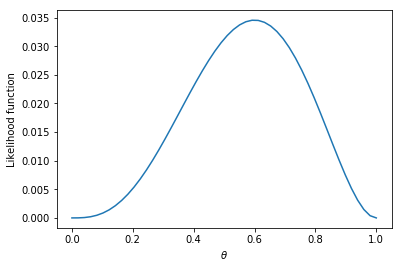

In [2]:
theta = np.linspace(0,1,50)
n = 5
k = 3
L = theta**k*(1-theta)**(n-k)
plt.plot(theta, L)
plt.ylabel(r'Likelihood function')
plt.xlabel(r'$\theta$')
plt.show()

- **MLE on conditional probability**

If we have a second coin C2, we observe,

| | First coin | Second coin |
|---|---|---|
|1|H|H|
|2|H|T|
|3|T|H|
|4|H|T|
|5|T|T|

We can similarly have,
$$P(C2 = H|C1 = H) = \frac{Number\ of\ C1=H,C2=H\ in\ observations}{Number\ of\ C1=H,C2=?\ in\ observations} = \frac{1}{3}$$

## 1. Problem set up 

When I use Google to **translate '大风'**, I get 'strong wind'. However, **'大' means big** and **'风' means wind**. Why it gives me **'strong wind' instead of 'big wind'?** 

I know 'strong' is better than 'big' when describing wind. How can Google translation know that? In another word, **what is the algorithm behind?**

- A straightforward idea is to **teach computer this rule**. When encountered 'big' and 'wind' together, change it to 'strong wind'. E.g., a **rule-based algorithm** is,

> raw_text = '大风'  
> translation = translate_by_word(raw_text)     # Here, we get translation = ['big', 'wind']  
> if (translation[0] == 'big' and translation[1] == 'wind'):  
> &nbsp;&nbsp;&nbsp;&nbsp; translation[0] = 'strong'
    
However, languages are complicated. There could be **so many rules, exceptions, and exceptions to exceptions**. When people try to capture all of them, the translation quality begins to break down.

- Another idea is, it is more **common** to say 'strong wind'. And **'common'** is saying higher **probability**. If we know $P('big\ wind') < P('strong\ wind')$, then this phenomenon can be well explained. After knowing the word meaning(not what we concern about today), the algorithm is **more likely to output 'strong wind'**.

Now the problem is **how to get the probability**.

## 2. Definition and Assumption

Let's define the problem more **scientifically**. **Given a sentence with n words, we define it as a sequence of n observations**. So a sentence can be represented as,
$$W := \{w_i\} =  \{w_1,w_2,w_3,...,w_n\}$$
where **$W$ denotes the sentence and $w_i$ denotes the ith word in the sentence**.

For example,
<center> **The cat is on the tree. = {the, cat, is, on, the, tree}** </center>
<center> **Cat eats big fish. = {cat, eats, big, fish}** </center>
<center> **There is a tree near the river. = {there, is, a, tree, near, the, river}** </center>
<center> **The fish in the river is big. = {the, fish, in, the, river, is, big}** </center>

Then the probability of a sentence becomes the probability of the sequence of words,
$$P(W) = P(w_1,w_2,w_3,...,w_n)$$

**Rely on the chain rule of probability**, (each word is not IID), the equation can be written as,
\begin{split}
P(W) &= P(w_1,w_2,w_3,...,w_n) \\
&= P(w_1)*P(w_2|w_1)*P(w_3|w_1,w_2)*...*P(w_n|w_1,w_2,w_3,...,w_{n-1})
\end{split}

Applying to the first example sentence above, we have,
\begin{split}
P(The\ cat\ is\ on\ the\ tree.) &= P(the, cat, is, on, the, tree) \\
&= P(the)*P(cat|the)*P(is|the, cat)*...*P(tree|the, cat, is, on, the)
\end{split}

We are not going to use this equation directly because some terms like $P(tree|the, cat, is, on, the)$ is **hard to estimate**. To estimate $P(tree|the, cat, is, on, the)$, **applying the conclusion from MLE**,
$$P(tree|the, cat, is, on, the) = \frac{Number\ of\ \{the, cat, is, on, the, tree\}\ in\ observations}{Number\ of\ \{the, cat, is, on, the, ?\}\ in\ observations}$$ 

The problem is, when there is no enough data, **this estimation is weak/inaccurate**. **Longer sequence is rare and hard to observe.** E.g., If we only have these 4 sentences, then 
$$P(tree|the, cat, is, on, the) = 1$$
$$P(table|the, cat, is, on, the) = 0$$

Therefore, it is necessary to make a simplifying assumption.
- **Markov Assumption**

**"The future is independent of the past given the present."**

Which is saying, next word only depends on current word.
$$ P(w_n|w_1,w_2,w_3,...,w_{n-1}) \approx P(w_n|w_{n-1}) $$

This assumption can be generalized like,
$$ P(w_n|w_1,w_2,w_3,...,w_{n-1}) \approx P(w_n|w_{n-k},...,w_{n-2},w_{n-1}) $$

where k is a number smaller than n-1.

That is saying, instead of using all the history, now we can **only use k-1 previous words**(k-2 past words and 1 current word).

If $k = 0$, the process is **totally momeryless**. **The occurance of every word is independent**. Then
\begin{split}
P(W) &= P(w_1,w_2,w_3,...,w_n) \\
&= P(w_1)*P(w_2)*P(w_3)*...*P(w_n) \\
&= \prod_{i=1}^n{P(w_i)}
\end{split}
In natural language processing, we call it **unigram model** or **bag of words model**.

The example above becomes,
\begin{split}
P(The\ cat\ is\ on\ the\ tree.) &= P(the, cat, is, on, the, tree) \\
&= P(the)*P(cat)*P(is)*P(on)*P(the)*P(tree)
\end{split}

If $k = 1$, it is called **bigram model**
\begin{split}
P(W) &= P(w_1,w_2,w_3,...,w_n) \\
&= P(w_1)*P(w_2|w_1)*P(w_3|w_2)*...*P(w_n|w_{n-1}) \\
&= P(w_1)*\prod_{i=2}^n{P(w_i|w_{i-1})}
\end{split}

If $k = n-1$, it is called **n-gram model**

- **Generative**

N-gram model is also generative. When we get the word distribution, **sampling from the distribution is regarded as a generative process**.

## 3. Examples of n-gram models

In [3]:
sentence = 'The cat is on the tree.'
unigram = list(ngrams(sentence.lower().rstrip('.').split(),1))
unigram.sort()
print('Unigram model: \n',unigram)

Unigram model: 
 [('cat',), ('is',), ('on',), ('the',), ('the',), ('tree',)]


The shortcoming of unigram model is **disregarding grammar and even word order**. You can easily construct **some counter examples**,

In [4]:
sentence = 'The tree is on the cat.'
unigram = list(ngrams(sentence.lower().rstrip('.').split(),1))
unigram.sort()
print('Unigram model: \n',unigram)

Unigram model: 
 [('cat',), ('is',), ('on',), ('the',), ('the',), ('tree',)]


In [5]:
sentence = 'The on is tree the cat.'
unigram = list(ngrams(sentence.lower().rstrip('.').split(),1))
unigram.sort()
print('Unigram model: \n',unigram)

Unigram model: 
 [('cat',), ('is',), ('on',), ('the',), ('the',), ('tree',)]


In [6]:
def build_pdf_matrix(text, n, add_k_smoothing = 0, permu = False): # n>=2
    if type(text) == list:
        if n == 1:
            ngram = []
            rows = ['frequency','probability']
            vocabulary = []
            for sentence in text:
                vocabulary = vocabulary + list(set(sentence.lower().rstrip('.').split()))
                ngram = ngram + list(ngrams(sentence.lower().rstrip('.').split(), n))
        else:
            ngram = []
            rows = []
            vocabulary = []
            for sentence in text:
                ngram = ngram + list(ngrams(sentence.lower().rstrip('.').split(), n))
                rows = rows + list(ngrams(sentence.lower().rstrip('.').split(), n-1))
                vocabulary = vocabulary + sentence.lower().rstrip('.').split()
                if n>2:
                    for i in range(n-1,1,-1):
                        ngram = ngram + list(ngrams(sentence.lower().rstrip('.').split()[:i], i))
                        rows = rows + list(ngrams(sentence.lower().rstrip('.').split()[:i-1], i-1))
    else:
        if n == 1:
            ngram = list(ngrams(text.lower().rstrip('.').split(), n))
            rows = ['frequency','probability']
            vocabulary = list(set(text.lower().rstrip('.').split()))
        else:
            ngram = list(ngrams(text.lower().rstrip('.').split(), n)) # ngrams won't sort inside
            rows = list(ngrams(text.lower().rstrip('.').split(), n-1))
            vocabulary = list(set(text.lower().rstrip('.').split()))
            if n>2:
                for i in range(n-1,1,-1):
                    ngram = ngram + list(ngrams(text.lower().rstrip('.').split()[:i], i))
                    rows = rows + list(ngrams(text.lower().rstrip('.').split()[:i-1], i-1))
    if permu == True:
        rows = rows + [p for p in itertools.product(vocabulary, repeat=2)]
    rows = list(set(rows))
    rows.sort()
    vocabulary = list(set(vocabulary))
    vocabulary.sort()
    matrix = add_k_smoothing * np.ones((len(rows), len(vocabulary)))
    if n == 1:
        for tuple in ngram:
            matrix[0,vocabulary.index(tuple[-1])] += 1
        if np.sum(matrix[0,:]) != 0:
            matrix[1,:] =matrix[0,:]/ np.sum(matrix[0,:])
    else:
        for tuple in ngram:
            matrix[rows.index(tuple[:-1]), vocabulary.index(tuple[-1])] += 1
        for i in range(len(rows)):
            if np.sum(matrix[i,:]) != 0:
                matrix[i,:] = matrix[i,:] / np.sum(matrix[i,:])

    df = pd.DataFrame(matrix, columns = vocabulary)
    df.insert(0, '', pd.Series(rows))
    return df

In [7]:
build_pdf_matrix(sentence, n = 1)

,,cat,is,on,the,tree
0,frequency,1.000000,1.000000,1.000000,2.000000,1.000000
1,probability,0.166667,0.166667,0.166667,0.333333,0.166667


In [8]:
text = ['The cat is on the tree.',
        'Cat eats big fish.',
        'There is a tree near the river.',
        'The fish in the river is big.']

In [9]:
df = build_pdf_matrix(text, n = 1)
df

,,a,big,cat,eats,fish,in,is,near,on,river,the,there,tree
0,frequency,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,3.000,1.000000,1.000000,2.000000,5.000000,1.000000,2.000000
1,probability,0.041667,0.083333,0.083333,0.041667,0.083333,0.041667,0.125,0.041667,0.041667,0.083333,0.208333,0.041667,0.083333


In [10]:
def calc_p(sentence, df, n):
    ngram = list(ngrams(sentence.lower().rstrip('.').split(), n))
    if n>2:
        for i in range(n-1,1,-1):
            ngram = ngram + list(ngrams(sentence.lower().rstrip('.').split()[:i], i))
    P = 1
    if n == 1:
        for tuple in ngram:
            P = P * df[tuple[0]][1]      
    else:
        for tuple in ngram:
            P = P * df[tuple[-1]][df[df[''] == tuple[:-1]].index.values[0]] 
    return P

In [11]:
sentence = 'The cat is on the tree.'
calc_p(sentence, df, 1)

1.5698342656893003e-06

In [12]:
sentence = 'The tree is on the cat.'
calc_p(sentence, df, 1)

1.5698342656893003e-06

If we **use a bigram model**, recall the bigram formular,
\begin{split}
P(W) &= P(w_1)*P(w_2|w_1)*P(w_3|w_2)*...*P(w_n|w_{n-1}) \\
&= P(w_1)*\prod_{i=2}^n{P(w_i|w_{i-1})}
\end{split}

In [13]:
bigram = list(ngrams(sentence.lower().rstrip('.').split(),2))
print('Bigram model: \n', bigram)

Bigram model: 
 [('the', 'tree'), ('tree', 'is'), ('is', 'on'), ('on', 'the'), ('the', 'cat')]


A little problem is we don't know **the probability of the first word in a sentence**. To overcome it, we can **add start symbol(SoS or <s\>)** and **end symbol(EoS or </s\>)** to each sentence.

In [44]:
sentence = '<s> the cat is on the tree <\s>'
bigram = list(ngrams(sentence.lower().rstrip('.').split(),2))
print('New bigram model: \n',bigram)

New bigram model: 
 [('<s>', 'the'), ('the', 'cat'), ('cat', 'is'), ('is', 'on'), ('on', 'the'), ('the', 'tree'), ('tree', '<\\s>')]


The formular becomes,
\begin{split}
P(W) &= P(<s>)*P(w_1|<s>)*P(w_2|w_1)*P(w_3|w_2)*...*P(w_n|w_{n-1})*P(<\s>|w_n) \\
&= P(<s>)*\prod_{i=1}^n{P(w_i|w_{i-1})}*P(<\s>|w_n)
\end{split}
where $P(<s>) = 1$ 

Now we can have more knowledge about which word usually appears at the **beginning or the end of a sentence**. Another benefit is we **can have different lengths of sentence**. 

If we want to use the the probability table to generate a new sentence, you have to tell it how many words you want. Then we sample words one by one from the distribution and form a sentence.

But now the algorithm can **generate by itself**. **The first word must be <s\>**. The algorithm will **keep sampling from the distribution until it outputs a <\s>**.

In [39]:
text = ['<s> the cat is on the tree <\s>',
        '<s> cat eats big fish <\s>',
        '<s> there is a tree near the river <\s>',
        '<s> the fish in the river is big <\s>']

In [40]:
df = build_pdf_matrix(text, n = 1, add_k_smoothing=0.01)
df

,,<\s>,<s>,a,big,cat,eats,fish,in,is,near,on,river,the,there,tree
0,frequency,4.010000,4.010000,1.010000,2.010000,2.010000,1.010000,2.010000,1.010000,3.010000,1.010000,1.010000,2.010000,5.010000,1.010000,2.010000
1,probability,0.124728,0.124728,0.031415,0.062519,0.062519,0.031415,0.062519,0.031415,0.093624,0.031415,0.031415,0.062519,0.155832,0.031415,0.062519


In [16]:
df = build_pdf_matrix(text, n = 1)
df

,,<\s>,<s>,a,big,cat,eats,fish,in,is,near,on,river,the,there,tree
0,frequency,4.000,4.000,1.00000,2.0000,2.0000,1.00000,2.0000,1.00000,3.00000,1.00000,1.00000,2.0000,5.00000,1.00000,2.0000
1,probability,0.125,0.125,0.03125,0.0625,0.0625,0.03125,0.0625,0.03125,0.09375,0.03125,0.03125,0.0625,0.15625,0.03125,0.0625


In [17]:
calc_p(sentence, df, 1)

4.3655745685100555e-09

In [18]:
df = build_pdf_matrix(text, n = 2)
df

,,<\s>,<s>,a,big,cat,eats,fish,in,is,near,on,river,the,there,tree
0,"(<\s>,)",0.0,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0
1,"(<s>,)",0.0,0.0,0.000000,0.000000,0.25,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.5,0.25,0.0
2,"(a,)",0.0,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,1.0
3,"(big,)",0.5,0.0,0.000000,0.000000,0.00,0.0,0.5,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0
4,"(cat,)",0.0,0.0,0.000000,0.000000,0.00,0.5,0.0,0.0,0.5,0.0,0.000000,0.0,0.0,0.00,0.0
5,"(eats,)",0.0,0.0,0.000000,1.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0
6,"(fish,)",0.5,0.0,0.000000,0.000000,0.00,0.0,0.0,0.5,0.0,0.0,0.000000,0.0,0.0,0.00,0.0
7,"(in,)",0.0,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.00,0.0
8,"(is,)",0.0,0.0,0.333333,0.333333,0.00,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.00,0.0
9,"(near,)",0.0,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.00,0.0


In [19]:
calc_p(sentence, df, 2)

0.0016666666666666668

You can imagine that **when using a trigram model, this probability will keep increasing**.

In [20]:
df = build_pdf_matrix(text, n = 3)
df

,,<\s>,<s>,a,big,cat,eats,fish,in,is,near,on,river,the,there,tree
0,"(<s>,)",0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.25,0.0
1,"(<s>, cat)",0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,"(<s>, the)",0.0,0.0,0.0,0.0,0.50,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,"(<s>, there)",0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0
4,"(a, tree)",0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.0
5,"(big, <\s>)",0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
6,"(big, fish)",1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
7,"(cat, eats)",0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
8,"(cat, is)",0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0
9,"(eats, big)",0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0


In [47]:
df = build_pdf_matrix(text, n = 3, add_k_smoothing=0.01)
df

,,<\s>,<s>,a,big,cat,eats,fish,in,is,near,on,river,the,there,tree
0,"(<s>,)",0.002410,0.002410,0.002410,0.002410,0.243373,0.002410,0.002410,0.002410,0.002410,0.002410,0.002410,0.002410,0.484337,0.243373,0.002410
1,"(<s>, cat)",0.008696,0.008696,0.008696,0.008696,0.008696,0.878261,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696
2,"(<s>, the)",0.004651,0.004651,0.004651,0.004651,0.469767,0.004651,0.469767,0.004651,0.004651,0.004651,0.004651,0.004651,0.004651,0.004651,0.004651
3,"(<s>, there)",0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.878261,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696
4,"(a, tree)",0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.878261,0.008696,0.008696,0.008696,0.008696,0.008696
5,"(big, <\s>)",0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
6,"(big, fish)",0.878261,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696
7,"(cat, eats)",0.008696,0.008696,0.008696,0.878261,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696
8,"(cat, is)",0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.878261,0.008696,0.008696,0.008696,0.008696
9,"(eats, big)",0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.878261,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696


In [48]:
calc_p(sentence, df, 3)

0.11889088003223312

## 4. Practical issues

The **probability** of reconstructing the sentence **increases significantly when using larger n-gram models**. However, more issues arise.

 - It is possible to have **new words in test set**.
 - The matrix is so sparse. **Most probabilities are 0s**.
 - The more gram we use, theoretically the performance should be better. But the upcoming issue is we need more training data, because **Longer sequence is rare and hard to observe.**
 
### 4.1 Issue with new words
One possible way is to **assign a fix probability** when encountering a new word. **Not very practical** because it is not easy to estimate that probability.

A better way is to **add another symbol** <UNK\> **to replace all the unknown words**. For example,
1. Choose a fixed vocabulary before training.
2. Replace all the words in the training set that is not in the vocabulary with the unknown word token <UNK\>.
3. Estimate the probabilities as usual.

### 4.2 Issue with zero probabilities
Zero probability means given a word 'A', it is impossible to have 'B' as the next one. Well, this could be true. It's more possible that **our training set don't have all phrases and usages**. 

**To solve the issue about zero probability**, we need to steal some probabilty from frequent words and give it to those rare words. This modification is called **smoothing or discounting**.

#### 4.2.1 Add-1 smoothing

Add-1 smoothing, also called Laplace smoothing, is the simplest way. **Add one to all the counts before we normalize them into probabilities**. Then there will be no 0 any more.
$$P_{Laplace}(w_i) = \frac{c_i+1}{n+v}$$
where n in the total number of words(grams) and v is the total number of vocabulary. Count $c_i$ is the number of word $w_i$.

In [22]:
df = build_pdf_matrix(text, n = 2, add_k_smoothing = 1)
df

,,<\s>,<s>,a,big,cat,eats,fish,in,is,near,on,river,the,there,tree
0,"(<\s>,)",0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
1,"(<s>,)",0.052632,0.052632,0.052632,0.052632,0.105263,0.052632,0.052632,0.052632,0.052632,0.052632,0.052632,0.052632,0.157895,0.105263,0.052632
2,"(a,)",0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.125000
3,"(big,)",0.117647,0.058824,0.058824,0.058824,0.058824,0.058824,0.117647,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
4,"(cat,)",0.058824,0.058824,0.058824,0.058824,0.058824,0.117647,0.058824,0.058824,0.117647,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
5,"(eats,)",0.062500,0.062500,0.062500,0.125000,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500
6,"(fish,)",0.117647,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.117647,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824,0.058824
7,"(in,)",0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.125000,0.062500,0.062500
8,"(is,)",0.055556,0.055556,0.111111,0.111111,0.055556,0.055556,0.055556,0.055556,0.055556,0.055556,0.111111,0.055556,0.055556,0.055556,0.055556
9,"(near,)",0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.125000,0.062500,0.062500


#### 4.2.2 Add-k smoothing

Add 1 may greatly change some probability.

Very similar to add-1 smoothing. Instead of add 1 to all the counts, add-k smoothing adds a **small value k**.
$$P_{Laplace}(w_i) = \frac{c_i+k}{n+k*v}$$
where k is usually **smaller than 1**. It can be 0.5, 0.05 or 0.01.

In [45]:
df = build_pdf_matrix(text, n = 2, add_k_smoothing = 0.01)
df

,,<\s>,<s>,a,big,cat,eats,fish,in,is,near,on,river,the,there,tree
0,"(<\s>,)",0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
1,"(<s>,)",0.002410,0.002410,0.002410,0.002410,0.243373,0.002410,0.002410,0.002410,0.002410,0.002410,0.002410,0.002410,0.484337,0.243373,0.002410
2,"(a,)",0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.878261
3,"(big,)",0.469767,0.004651,0.004651,0.004651,0.004651,0.004651,0.469767,0.004651,0.004651,0.004651,0.004651,0.004651,0.004651,0.004651,0.004651
4,"(cat,)",0.004651,0.004651,0.004651,0.004651,0.004651,0.469767,0.004651,0.004651,0.469767,0.004651,0.004651,0.004651,0.004651,0.004651,0.004651
5,"(eats,)",0.008696,0.008696,0.008696,0.878261,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696
6,"(fish,)",0.469767,0.004651,0.004651,0.004651,0.004651,0.004651,0.004651,0.469767,0.004651,0.004651,0.004651,0.004651,0.004651,0.004651,0.004651
7,"(in,)",0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.878261,0.008696,0.008696
8,"(is,)",0.003175,0.003175,0.320635,0.320635,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.320635,0.003175,0.003175,0.003175,0.003175
9,"(near,)",0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.008696,0.878261,0.008696,0.008696


In [46]:
calc_p(sentence, df, 2)

0.001157647748223976

### 4.3 Issue with rare long sequences

An example is, a test sentence 'I love Hong Kong.'. It's not in the training set. $P(Kong|love, Hong)$ is bad. But $P(Kong|Hong)$ is really high.

As for our toy example, we have 4 sentences, 15 tokens. Using bigram, we will have 15 rows. Using trigram, there should be **15*15=225 possible rows, but we only have 27!** We cannot observe all possible sequence in only 4 sentences. Further more, **if a n-gram model have k words, the size of matrix will be $k^{n-1} \times k$!**

**In practice, training corpus is never exhaustive.** Sometimes we **have no examples of a particular trigram**, we can **instead estimate its probability by using the bigram probability** $P(w_n|w_{n−1})$, or even unigram probability $P(w_n)$.

Further more, it is possible to **interpolate all possible grams** to get a **weighted** equation,
\begin{split}
P(w_n|w_{n−2},w_{n−1}) =& \lambda_1*P(w_n|w_{n−2},w_{n−1}) + \lambda_2*P(w_n|w_{n−1}) + \lambda_3*P(w_n)
\end{split}
such that $\sum{\lambda_i} = 1$

## 5. Performance on generating sentences

Besides calculating the probability of a sentence, N-gram model can generate sentences.

In [24]:
def pdf_to_cdf(df, n):
    if n == 1:
        previous_word = df.columns[1]
        for word in df.columns[2:]:
            df[word][1] = df[word][1] + df[previous_word][1]
            previous_word = word
        return df
    else:
        np_array = df.values[:,1:]
        M,N = np.shape(np_array)
        for i in range(M):
#             if i%20 == 0:
#                 print(i)
            for j in range(N):
                if j != 0:
                    np_array[i,j] += np_array[i,j-1]
        df_new = pd.DataFrame(np_array, columns = df.columns[1:])
        df_new.insert(0, '', pd.Series(df['']))
        return df_new

In [25]:
def generate_sentence(df, n):
    if n == 1:
        sentence = ['<s>']
        row = df.index[df[''] == 'probability'][0]
        while (sentence[-1] != '<\s>'):
            p = np.random.rand(1)[0]
            for i,v in enumerate(df.loc[row][1:]):
                if p < v:
                    if (df.columns[i+1] == '<s>'):
                        continue
                    else:
                        sentence.append(df.columns[i+1])
                        break
    else:
        sentence = ['<s>']
        while (sentence[-1] != '<\s>'):
            if sentence[-1] == '<s>':
                row = df.index[df[''] == (sentence[-1],)][0]
                p = np.random.rand(1)[0]
                for i,v in enumerate(df.loc[row][1:]):
                    if p < v:
                        if (df.columns[i+1] == '<s>'):
                            continue
                        else:
                            sentence.append(df.columns[i+1])
                            break
            else:
                row = df.index[df[''] == tuple(sentence[-n+1:])][0]
                p = np.random.rand(1)[0]
                for i,v in enumerate(df.loc[row][1:]):
                    if p < v:
                        if (df.columns[i+1] == '<s>'):
                            continue
                        else:
                            sentence.append(df.columns[i+1])
                            break
    return sentence

In [26]:
df1 = build_pdf_matrix(text, n = 1, add_k_smoothing = 0.01)
df_cdf_1 = pdf_to_cdf(df1, 1)

In [27]:
df2 = build_pdf_matrix(text, n = 2, add_k_smoothing = 0.01)
df_cdf_2 = pdf_to_cdf(df2, 2)

In [28]:
df3 = build_pdf_matrix(text, n = 3, add_k_smoothing = 0.01, permu=True)
df_cdf_3 = pdf_to_cdf(df3, 3)

In [29]:
df_cdf_1

,,<\s>,<s>,a,big,cat,eats,fish,in,is,near,on,river,the,there,tree
0,frequency,4.010000,4.010000,1.010000,2.01000,2.01000,1.010000,2.010000,1.01000,3.010000,1.010000,1.010000,2.010000,5.010000,1.010000,2.01
1,probability,0.124728,0.249456,0.280871,0.34339,0.40591,0.437325,0.499844,0.53126,0.624883,0.656299,0.687714,0.750233,0.906065,0.937481,1.00


In [30]:
print('Sentences generated by unigram model')
for i in range(5):
    print(generate_sentence(df_cdf_1, 1))

Sentences generated by unigram model
['<s>', 'river', '<\\s>']
['<s>', 'the', 'is', 'is', 'there', 'the', 'big', 'big', 'there', 'the', 'tree', 'on', 'the', 'a', 'a', 'a', 'is', 'big', 'a', 'a', 'the', 'fish', 'the', 'fish', 'is', 'is', 'cat', '<\\s>']
['<s>', 'is', 'tree', '<\\s>']
['<s>', 'river', 'cat', 'is', '<\\s>']
['<s>', 'big', 'on', 'there', 'a', 'fish', 'near', '<\\s>']


In [31]:
print('Sentences generated by bigram model')
for i in range(5):
    print(generate_sentence(df_cdf_2, 2))

Sentences generated by bigram model
['<s>', 'the', 'tree', 'near', 'the', 'tree', '<\\s>']
['<s>', 'the', 'cat', 'is', 'on', 'a', 'tree', 'near', 'the', 'fish', '<\\s>']
['<s>', 'the', 'tree', '<\\s>']
['<s>', 'the', 'river', '<\\s>']
['<s>', 'cat', 'eats', 'big', 'fish', 'in', 'the', 'cat', 'eats', 'big', '<\\s>']


In [52]:
print('Sentences generated by trigram model')
for i in range(5):
    print(generate_sentence(df_cdf_3, 3))

Sentences generated by trigram model
['<s>', 'there', 'is', 'a', 'tree', 'near', 'the', 'river', '<\\s>']
['<s>', 'cat', 'eats', 'big', 'fish', '<\\s>']
['<s>', 'the', 'fish', 'in', 'the', 'river', '<\\s>']
['<s>', 'the', 'cat', 'is', 'on', 'the', 'the', 'river', '<\\s>']
['<s>', 'the', 'fish', 'in', 'the', 'fish', 'in', 'the', 'river', 'river', 'cat', 'on', 'near', 'tree', 'a', '<\\s>']


### Performance on real corpus

Data from nltk.corpus.brown

Result sometime is not human interpretable, if the corpus is small and **vacabulary is large**.

I tried trigram, but the matrix is so big and the Ipython kernel broke down.

In [33]:
from nltk.corpus import brown
brown_corpus = list(brown.sents(categories='adventure'))
text = []
for sent in brown_corpus:
    sentence = '<s>'
    for word in sent:
        if word == "''":
            continue
        elif word == "``":
            continue
        elif word == "--":
            continue
        if word == '?' and sentence[-1] == '?':
            continue
        elif word == '!' and sentence[-1] == '!':
            continue
        elif word == ',' and sentence[-1] == ',':
            continue
        elif word == ';' and sentence[-1] == ';':
            continue
        sentence = sentence + ' ' + word
    if sentence != '<s>':
        text.append(sentence + ' <\s>')
print('number of sentences:',len(text))

number of sentences: 4631


In [34]:
text[4600:]

['<s> Ernie hesitated a moment . <\\s>',
 '<s> This character could break him in half . <\\s>',
 '<s> Sure , he said , and lifted the pint to his own lips . <\\s>',
 '<s> He guzzled down three-quarters of the strong home-blend and proffered the remainder . <\\s>',
 '<s> The man stalked toward them , his big boots heavy on the wooden flooring . <\\s>',
 '<s> He took the bottle with undue belligerence , and making sucking noises with his thick lips , drained it completely . <\\s>',
 '<s> He threw his head back , closed his eyes , and belched ferociously . <\\s>',
 '<s> He belched again , and opening his eyes , threw the bottle out the open door . <\\s>',
 '<s> Well , now , he said , and reached into his pocket . <\\s>',
 "<s> I didn't know I was gonna have company in this car . <\\s>",
 "<s> We're going to Philadelphia , Kitty said , pulling her skirt down around her legs all the more . <\\s>",
 "<s> No , I don't think so , said the big man , and it was the final clincher for Ernie . <\\

In [35]:
df = build_pdf_matrix(text, n = 2, add_k_smoothing = 0.001)

In [36]:
df

,,!,$125,$30,$600,&,','cept,'em,'fore,...,youth,youthful,yucca,yuh,zealously,zero,zeros,zigzagging,zing,zingggg-o
0,"(!,)",6.050046e-06,6.050046e-06,6.050046e-06,6.050046e-06,6.050046e-06,6.050046e-06,6.050046e-06,6.050046e-06,6.050046e-06,...,6.050046e-06,6.050046e-06,6.050046e-06,6.050046e-06,6.050046e-06,6.050046e-06,6.050046e-06,6.050046e-06,6.050046e-06,6.050046e-06
1,"($125,)",1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,...,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04
2,"($30,)",1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,...,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04
3,"($600,)",9.720062e-05,9.720062e-05,9.720062e-05,9.720062e-05,9.720062e-05,9.720062e-05,9.720062e-05,9.720062e-05,9.720062e-05,...,9.720062e-05,9.720062e-05,9.720062e-05,9.720062e-05,9.720062e-05,9.720062e-05,9.720062e-05,9.720062e-05,9.720062e-05,9.720062e-05
4,"(&,)",1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,...,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04
5,"(',)",4.294057e-05,4.294057e-05,4.294057e-05,4.294057e-05,4.294057e-05,4.294057e-05,4.294057e-05,4.294057e-05,4.294057e-05,...,4.294057e-05,4.294057e-05,4.294057e-05,4.294057e-05,4.294057e-05,4.294057e-05,4.294057e-05,4.294057e-05,4.294057e-05,4.294057e-05
6,"('cept,)",1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,...,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04
7,"('em,)",1.479200e-01,4.929022e-05,4.929022e-05,4.929022e-05,4.929022e-05,4.929022e-05,4.929022e-05,4.929022e-05,4.929022e-05,...,4.929022e-05,4.929022e-05,4.929022e-05,4.929022e-05,4.929022e-05,4.929022e-05,4.929022e-05,4.929022e-05,4.929022e-05,4.929022e-05
8,"('fore,)",1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,...,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04
9,"('pache,)",1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,...,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04,1.076658e-04


In [37]:
df_cdf = pdf_to_cdf(df, 2)

In [38]:
for i in range(5):
    print(generate_sentence(df_cdf, 2))

['<s>', 'rob', 'hunters', 'pot', ',', 'he', 'opened', 'college', 'company', 'ripple', 'fearfully', 'thighs', 'faltered', 'grounds', 'smack', '!', '<\\s>']
['<s>', "you're", 'about', 'the', 'german', 'will', 'be', 'fried', 'release', 'newspaperman', 'like', 'meat', 'before', 'any', 'kamikaze', 'case', 'displeasure', 'palazzos', 'untenanted', 'painter', 'island', 'woman', 'eyed', 'slipped', 'pacific', 'winding', 'gagged', 'eagles', "d'you", 'influence', 'gruff', 'breath', '.', '<\\s>']
['<s>', 'he', 'sneezed', '.', '<\\s>']
['<s>', 'and', 'partly', 'stoop', 'stay', "'cept", 'sixty', 'coral', 'blew', 'ankles', 'silver', 'storefront', "rubbin'", 'agin', 'cover', 'missy', 'beetling', 'weeds', 'bulls', 'rode', 'in', 'my', 'name', ',', 'drained', 'it', 'was', 'almost', 'point', 'in', 'the', 'white', 'hair', 'streamed', 'backwards', 'yourself', '.', '<\\s>']
['<s>', 'in', 'which', 'had', 'a', 'firm', 'worldly', 'quitting', 'sticky', 'detonation', 'fluorescent', 'depend', 'adapt', 'roar', 'mond